In [8]:
#100043
import alpaca_trade_api as tradeapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


#paper api
#api = tradeapi.REST('PK0LC2J1NSMU3IUAXF31', 'VpfhPftx0Wvmkn5PoOKabFcUUHrCSxQ8LF8dri3s', base_url='https://paper-api.alpaca.markets')

api = tradeapi.REST('AKYZUR3PABG4AH39LMUC','GyCiPu5SQXovKXLl4QLe2JbXcXNfCzomjNjiVAmT','https://api.alpaca.markets')

[*********************100%%**********************]  1 of 1 completed
/var/folders/bz/b_4v54bn5w5dt4bf65s2qfch0000gn/T/ipykernel_92370/3688993718.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['Close'][i] > data['SMA_50'][i] and data['MACD'][i] > data['Signal_Line'][i] and data['RSI_14'][i] < 70:
/var/folders/bz/b_4v54bn5w5dt4bf65s2qfch0000gn/T/ipykernel_92370/3688993718.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif data['Close'][i] < data['EMA_20'][i] and data['MACD'][i] < data['Signal_Line'][i] and data['RSI_14'][i] > 30:


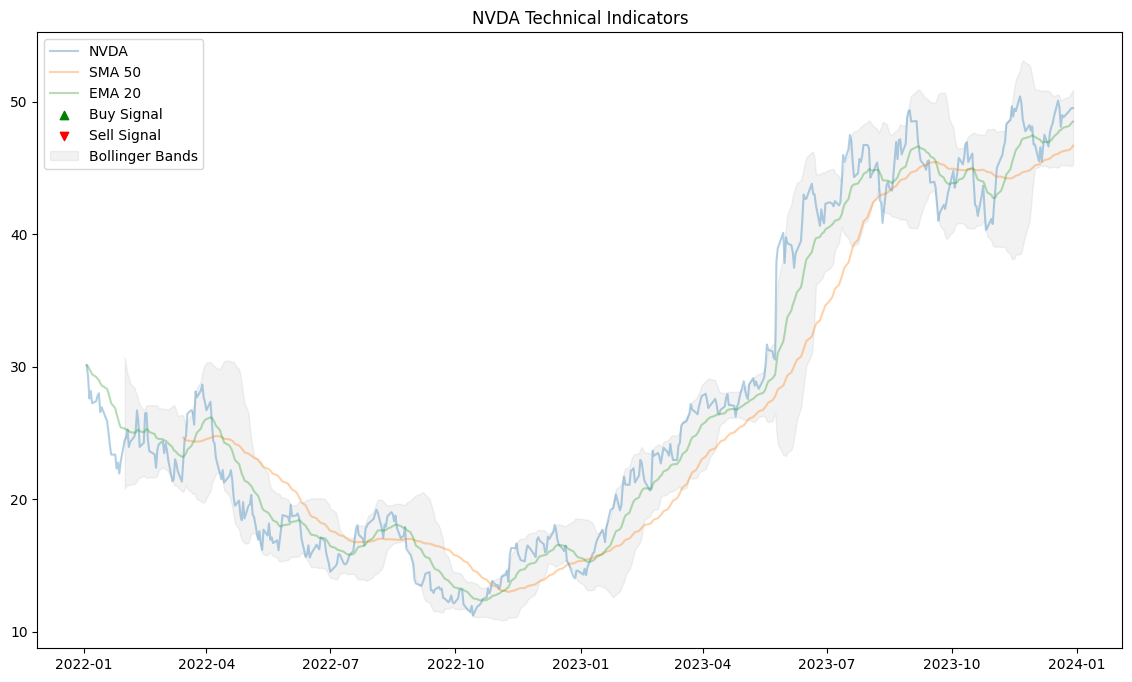

In [15]:
def SMA(data, window):
    return data['Close'].rolling(window=window).mean()

def EMA(data, window):
    return data['Close'].ewm(span=window, adjust=False).mean()

def RSI(data, window=14):
    delta = data['Close'].diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def MACD(data, short_window=12, long_window=26, signal_window=9):
    short_ema = EMA(data, short_window)
    long_ema = EMA(data, long_window)
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

def Bollinger_Bands(data, window=20, num_std=2):
    sma = SMA(data, window)
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + (std * num_std)
    lower_band = sma - (std * num_std)
    return upper_band, lower_band

def ATR(data, window=14):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    atr = true_range.rolling(window=window).mean()
    return atr

# Fetch historical data
ticker = 'NVDA'
data = yf.download(ticker, start="2022-01-01", end="2024-01-01")

# Apply indicators
data['SMA_50'] = SMA(data, 50)
data['EMA_20'] = EMA(data, 20)
data['RSI_14'] = RSI(data)
data['MACD'], data['Signal_Line'] = MACD(data)
data['Upper_Band'], data['Lower_Band'] = Bollinger_Bands(data)
data['ATR'] = ATR(data)

# Fibonacci Retracement (Assume we calculate for the last major trend)
data['Min'] = data['Close'].min()
data['Max'] = data['Close'].max()
fib_levels = [0.236, 0.382, 0.5, 0.618, 0.786]
for level in fib_levels:
    data[f'Fib_{level}'] = data['Max'] - (data['Max'] - data['Min']) * level

# Example Strategy
buy_signals = []
sell_signals = []

for i in range(len(data)):
    if data['Close'][i] > data['SMA_50'][i] and data['MACD'][i] > data['Signal_Line'][i] and data['RSI_14'][i] < 70:
        buy_signals.append(data['Close'][i])
        sell_signals.append(np.nan)
    elif data['Close'][i] < data['EMA_20'][i] and data['MACD'][i] < data['Signal_Line'][i] and data['RSI_14'][i] > 30:
        sell_signals.append(data['Close'][i])
        buy_signals.append(np.nan)
    else:
        buy_signals.append(np.nan)
        sell_signals.append(np.nan)

data['Buy_Signal'] = buy_signals
data['Sell_Signal'] = sell_signals

# Plotting
plt.figure(figsize=(14, 8))
plt.plot(data['Close'], label=ticker, alpha=0.35)
plt.plot(data['SMA_50'], label='SMA 50', alpha=0.35)
plt.plot(data['EMA_20'], label='EMA 20', alpha=0.35)
plt.scatter(data.index, data['Buy_Signal'], label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(data.index, data['Sell_Signal'], label='Sell Signal', marker='v', color='red', alpha=1)
plt.fill_between(data.index, data['Upper_Band'], data['Lower_Band'], color='gray', alpha=0.1, label='Bollinger Bands')
plt.title(f'{ticker} Technical Indicators')
plt.legend(loc='upper left')
plt.show()

[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  1 of 1 completed


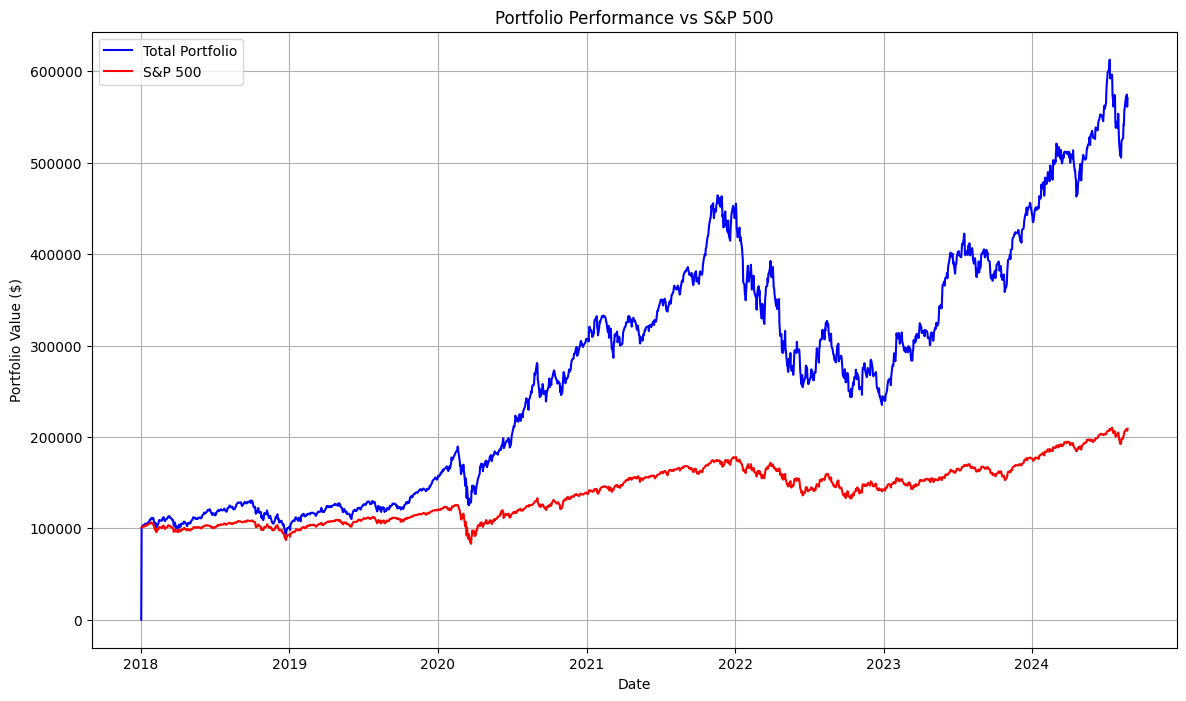

            Trend Following  Volatility Breakout    Retracement  \
Date                                                              
2024-08-19     95533.471655        240007.680302  148631.049432   
2024-08-20     95965.347016        241165.893735  147527.786155   
2024-08-21     95645.633385        242516.192598  149136.019398   
2024-08-22     94342.522524        233874.417685  145895.992480   
2024-08-23     95109.315158        238882.502286  148000.639462   

            Comprehensive Market  Short-Term Trading  Total Portfolio  
Date                                                                   
2024-08-19          42254.923826        45594.582464    572021.707678  
2024-08-20          41641.323581        45360.709629    571661.060115  
2024-08-21          41643.465817        45680.114158    574621.425356  
2024-08-22          41986.372996        45184.914447    561284.220132  
2024-08-23          42612.071428        45989.292156    570593.820490  


In [17]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

strategies = {
    "Trend Following": ["AAPL", "MSFT", "GOOGL"],
    "Volatility Breakout": ["TSLA", "AMD", "NFLX"],
    "Retracement": ["AMZN", "NVDA", "META"],
    "Comprehensive Market": ["JPM", "GS", "BAC"],
    "Short-Term Trading": ["SPY", "QQQ", "IWM"]
}

start_date = "2018-01-01"
end_date = datetime.now().strftime('%Y-%m-%d')

def calculate_strategy_returns(stocks, initial_allocation):
    data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
    returns = data.pct_change().mean(axis=1)
    cumulative_returns = (1 + returns).cumprod() * initial_allocation
    return cumulative_returns

portfolio_returns = {}

for strategy, stocks in strategies.items():
    portfolio_returns[strategy] = calculate_strategy_returns(stocks, 20000)

portfolio_df = pd.DataFrame(portfolio_returns)

portfolio_df['Total Portfolio'] = portfolio_df.sum(axis=1)

sp500_data = yf.download("^GSPC", start=start_date, end=end_date)['Adj Close']
sp500_returns = (1 + sp500_data.pct_change()).cumprod() * 100000

plt.figure(figsize=(14, 8))
plt.plot(portfolio_df.index, portfolio_df['Total Portfolio'], label="Total Portfolio", color="blue")
plt.plot(sp500_returns.index, sp500_returns, label="S&P 500", color="red")
plt.title('Portfolio Performance vs S&P 500')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

print(portfolio_df.tail())
